# AlBert for Nepali (NepCov19Tweets) Sentiment Analysis.
**Sentiment Analysis on NepCov19Tweets Dataset, a collection of tweets in Nepali (Devnagari Script) regarding/during pandemic period.**

In [21]:
!pip install transformers datasets huggingface-hub --quiet

In [22]:
import numpy as np
import random
import os
import tensorflow as tf
from transformers import set_seed

rand_seed = 99

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.keras.utils.set_random_seed(seed)
    set_seed(seed)
    
seed_everything(rand_seed)

## Model Selection and Preparation

### Loading Model
**and model hyper-parameter tuning**

In [23]:
from transformers import TFAutoModelForSequenceClassification, AlbertConfig

if False: ### Using Pre-trained (English) albert-base-v2
  model = TFAutoModelForSequenceClassification.from_pretrained('albert-base-v2',
              id2label={0:"NEUTRAL",1:"POSITIVE",2:"NEGATIVE"},
              label2id={"NEUTRAL":0,"POSITIVE":1,"NEGATIVE":2})
elif True:  ### Using Pre-trained (Nepali) raygx/Albert-Bhai-Nepali
  model = TFAutoModelForSequenceClassification.from_pretrained('raygx/Albert-Bhai-Nepali',
              id2label={0:"NEUTRAL",1:"POSITIVE",2:"NEGATIVE"},
              label2id={"NEUTRAL":0,"POSITIVE":1,"NEGATIVE":2})
else: ### Randomnly Initializing Model;
  model = TFAutoModelForSequenceClassification.from_config(config=AlbertConfig('albert-base-v2',
            id2label={0:"NEUTRAL",1:"POSITIVE",2:"NEGATIVE"},
            label2id={"NEUTRAL":0,"POSITIVE":1,"NEGATIVE":2}))

All model checkpoint layers were used when initializing TFAlbertForSequenceClassification.

Some layers of TFAlbertForSequenceClassification were not initialized from the model checkpoint at raygx/Albert-Bhai-Nepali and are newly initialized: ['classifier', 'albert/pooler/kernel:0', 'albert/pooler/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
from transformers import AlbertTokenizerFast

tokenizer = AlbertTokenizerFast.from_pretrained('raygx/Albert-Bhai-Nepali')
model.resize_token_embeddings(len(tokenizer))

<tf.Variable 'tf_albert_for_sequence_classification_1/albert/embeddings/word_embeddings/weight:0' shape=(30001, 128) dtype=float32, numpy=
array([[-0.00257458, -0.01249851, -0.03357233, ..., -0.0150874 ,
         0.00208345, -0.02378185],
       [ 0.036135  ,  0.02758075, -0.00577225, ...,  0.00421843,
        -0.02217576,  0.01035095],
       [ 0.03458647,  0.03707005,  0.02734535, ...,  0.03211867,
        -0.02426202,  0.01222699],
       ...,
       [ 0.00121513,  0.01902641, -0.01492319, ...,  0.0053486 ,
        -0.04247945,  0.01594521],
       [ 0.02390956,  0.03034714,  0.01985654, ...,  0.0265486 ,
         0.0006229 ,  0.0047668 ],
       [ 0.03127494,  0.00771207,  0.0239792 , ...,  0.0354004 ,
        -0.0376986 ,  0.05406245]], dtype=float32)>

In [25]:
print(model.summary())
model.config

Model: "tf_albert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 albert (TFAlbertMainLayer)  multiple                  11683712  
                                                                 
 dropout_9 (Dropout)         multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 11,686,019
Trainable params: 11,686,019
Non-trainable params: 0
_________________________________________________________________
None


AlbertConfig {
  "_name_or_path": "raygx/Albert-Bhai-Nepali",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 2,
  "classifier_dropout": null,
  "classifier_dropout_prob": 0.1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "NEUTRAL",
    "1": "POSITIVE",
    "2": "NEGATIVE"
  },
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "label2id": {
    "NEGATIVE": 2,
    "NEUTRAL": 0,
    "POSITIVE": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.29.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30001
}

### Optimizer Selection and Hyperparameter Tuning

In [26]:
from transformers import create_optimizer, AdamWeightDecay

optimizer = AdamWeightDecay(learning_rate=9e-6, weight_decay_rate=0.001)
model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


# Dataset Selection and Prepartion

**Loading Dataset**

In [27]:
import datasets

data = datasets.load_dataset("raygx/NepCov19TweetsPlus")
data = data.shuffle(rand_seed)
data = data['train'].train_test_split(test_size=0.2)
data = data.rename_columns({"Sentences":"text","Sentiment":"labels"})
data

  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 33240
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 8310
    })
})

### Label Encoding

In [28]:
%%time
def LabelEncoding(x):
    if x['labels']==0:
        x['labels'] = 0#[1,0,0]
    if x['labels']==1:
        x['labels'] =  1#[0,1,0]
    if x['labels']==-1:
        x['labels'] =  2#[0,0,1]
    
    return x

data = data.map(
        LabelEncoding,
        num_proc=4)

data

CPU times: user 37.8 ms, sys: 976 µs, total: 38.8 ms
Wall time: 52.8 ms


DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 33240
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 8310
    })
})

### Tokenization

In [29]:
%%time

def preprocess_function(rows):
    return globals()['tokenizer'](rows['text'],truncation=True)

print("Tokenizing the data")
tokenized_inputs = data.map(
    preprocess_function,
    batched=True,
    num_proc=2,
    remove_columns=data["train"].column_names,
)
tokenized_inputs = tokenized_inputs.remove_columns(['token_type_ids'])

tokenized_inputs['train'] = tokenized_inputs['train'].add_column(
    name="labels",column=data['train']['labels']
)
tokenized_inputs['test'] = tokenized_inputs['test'].add_column(
    name="labels",column=data['test']['labels']
)

tokenized_inputs

Tokenizing the data
CPU times: user 221 ms, sys: 1.89 ms, total: 223 ms
Wall time: 254 ms


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 33240
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 8310
    })
})

### Initializing the Data Collator

In [30]:
from transformers import DataCollatorWithPadding

print("Initializing Data Collator")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, 
                                        max_length=128,
                                        return_tensors="tf")

Initializing Data Collator


In [31]:
print("Preparing Training and Testing sets to TRAIN the MODEL")
tf_train_set = model.prepare_tf_dataset(
    tokenized_inputs["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_test_set = model.prepare_tf_dataset(
    tokenized_inputs["test"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

You're using a AlbertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Preparing Training and Testing sets to TRAIN the MODEL


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


## Training and Evaluation

In [32]:
%%time

n_epoch = 5

print("Training the model")
history = model.fit(x=tf_train_set, 
          validation_data=tf_test_set,
          epochs=n_epoch)

Training the model
Epoch 1/5
2077/2077 [==============================] - 437s 194ms/step - loss: 0.7881 - val_loss: 0.6864
Epoch 2/5
2077/2077 [==============================] - 403s 194ms/step - loss: 0.6483 - val_loss: 0.6607
Epoch 3/5
2077/2077 [==============================] - 403s 194ms/step - loss: 0.5736 - val_loss: 0.6212
Epoch 4/5
2077/2077 [==============================] - 404s 195ms/step - loss: 0.5090 - val_loss: 0.6161
Epoch 5/5
2077/2077 [==============================] - 405s 195ms/step - loss: 0.4540 - val_loss: 0.6338
CPU times: user 28min 32s, sys: 2min 6s, total: 30min 39s
Wall time: 36min 7s


**Loss Graph Visualization**

<Axes: >

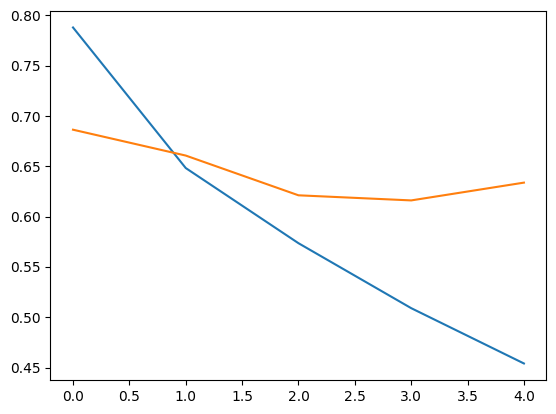

In [33]:
import seaborn

seaborn.lineplot(history.history['loss'])
seaborn.lineplot(history.history['val_loss'])

### Evaluation

In [34]:
%%time
from transformers import pipeline, TextClassificationPipeline

print("Getting Test Prediction")
pipe = pipeline('sentiment-analysis',model=model,tokenizer=tokenizer,device=1)
prediction = pipe(data['test']['text'])
pred_labels = [model.config.label2id[x['label']] for x in prediction]

actual_labels = data['test']['labels']

Getting Test Prediction
CPU times: user 32min 23s, sys: 8.92 s, total: 32min 32s
Wall time: 32min 44s


**Computing F1-Score, Precision, Recall and Accuracy of the Model**

In [35]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

print("F1-Score",f1_score(actual_labels,pred_labels,average='weighted'))
print("Precision-Score",precision_score(actual_labels,pred_labels,average='weighted'))
print("Recall-Score",recall_score(actual_labels,pred_labels,average='weighted'))
print("accuracy_Score",accuracy_score(actual_labels,pred_labels))

F1-Score 0.7409970950990628
Precision-Score 0.7438636909006413
Recall-Score 0.7406738868832732
accuracy_Score 0.7406738868832732


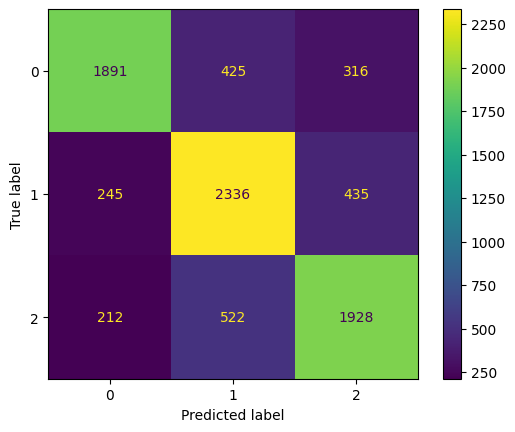

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cmd = ConfusionMatrixDisplay(tf.math.confusion_matrix(actual_labels,pred_labels,num_classes=3).numpy())
cmd.plot()